In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score, accuracy_score, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

import visuals as vs
import time

# DataFrame import and preparation

In [2]:
df = pd.read_csv('Dataframe raw.csv', sep = ';')
df_final = pd.read_csv('DataFrame.csv', sep = ';', index_col = 0)

In [3]:
#separation of input and output for the first model
df_input_prod = df_final.iloc[:,1:16].drop(['ES Service'], axis= 1) #remove service
df_output = df_final.iloc[:,16:]

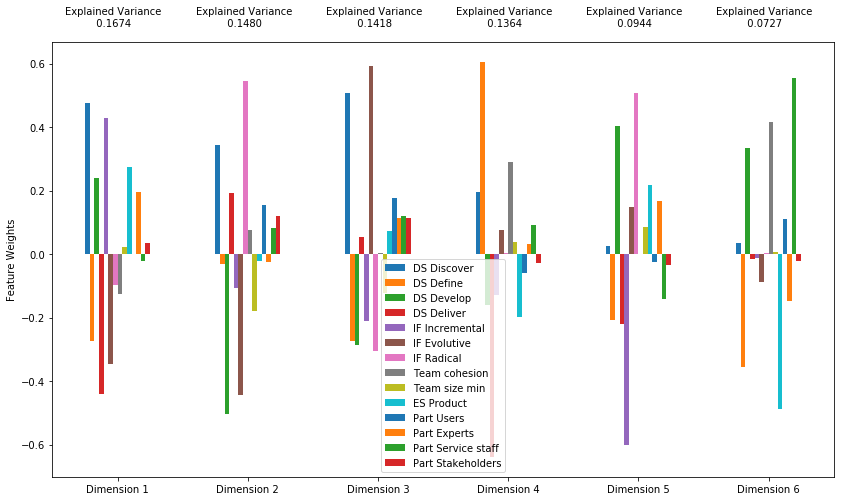

In [4]:
pca_prod = PCA(n_components = 6)
pca_prod.fit(df_input_prod)
pca_prod_results = vs.pca_results(df_input_prod, pca_prod)

In [5]:
#function for checking zeroes on the scoring of models
#some models could provide training/testing errors, attributing 0 to all socres. This function eliminates these lines.

def check_zeroes(score_prod_gridsearch):
    test_score = pd.DataFrame(columns = range(10))
    for j in range(10):
        test_score[j] = clf.cv_results_['split'+str(j)+'_test_score']
        if sum(clf.cv_results_['split'+str(j)+'_test_score']) == 0:
            test_score.drop([j], axis=1, inplace = True)

    array_means = np.average(test_score, axis=1)
    array_means = array_means.reshape(-1, 1)
    array_std = np.array(np.std(test_score, axis=1))
    array_std = array_std.reshape(-1, 1)
    
    score_prod_gridsearch.iloc[i,2:3] = array_means[best_index][0]
    score_prod_gridsearch.iloc[i,3:4] = array_std[best_index][0]
    
    return score_prod_gridsearch

# Models testing
All models bellow were tested using gridsearch with specific parameters, aiming for the best results for each target feature

# k-NN

In [6]:
from sklearn.neighbors import KNeighborsRegressor

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std', 'n_neighbors'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = KNeighborsRegressor()
    parameters = {'n_neighbors': [3, 5, 7, 9]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index], clf.best_params_['n_neighbors']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/10)
score_prod_gridsearch

0.4025604248046875


,Train score,Train std,Test score,Test std,n_neighbors
Execution time,0.867031,0.00836911,0.732666,0.20477,3
Difficulty of use,0.765526,0.0122391,0.608391,0.209654,3
CIT Structure,0.866479,0.0063342,0.793144,0.110293,3
CC Users,0.796464,0.0110426,0.718538,0.16876,3
CC Organization,0.84436,0.00514041,0.740678,0.108715,3
CC Business,0.649717,0.0242918,0.0575114,1.69242,3
CC Frame,0.848624,0.00942138,0.652465,0.352806,3
CC Concepts,0.935114,0.00423915,0.872785,0.0604143,3
CC Prototypes,0.871945,0.00790577,0.792221,0.10263,3


# SVR rbf

In [7]:
from sklearn.svm import SVR

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std',
                                                                                        'Test score', 'Test std', 'C', 'Gamma'])

start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = SVR(kernel = 'rbf')
    parameters = {'C':[1, 10, 50, 100], 'gamma':[0.01, 0.1, 0.5, 1]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index],
                                        clf.best_params_['C'], clf.best_params_['gamma']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/10)
score_prod_gridsearch.to_csv(r'ML_Export.csv')
score_prod_gridsearch

5.428672337532044


,Train score,Train std,Test score,Test std,C,Gamma
Execution time,0.925194,0.00511852,0.791495,0.115929,100,1
Difficulty of use,0.910935,0.00525213,0.700952,0.136974,100,1
CIT Structure,0.926883,0.00258601,0.886984,0.0438852,100,0.5
CC Users,0.912784,0.00848732,0.73393,0.152782,100,1
CC Organization,0.909216,0.00849332,0.759863,0.119509,100,1
CC Business,0.821854,0.0110126,0.158917,1.08811,100,1
CC Frame,0.835444,0.00941377,0.655076,0.242403,1,0.5
CC Concepts,0.947254,0.00232955,0.83426,0.131135,100,1
CC Prototypes,0.931066,0.00598169,0.804814,0.106853,100,1


# SVR poly

In [8]:
from sklearn.svm import SVR

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std', 'Degree', 'C', 'Gamma'])

start = time.time()
for i in range(df_output.shape[1]):
    estimator = SVR(kernel = 'poly')
    parameters = {'degree':[2, 3, 4, 5], 'C':[1, 10, 20], 'gamma':[0.1, 0.5, 1]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index],
                                        clf.best_params_['degree'], clf.best_params_['C'], clf.best_params_['gamma']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/10)
score_prod_gridsearch

66.55055756568909


,Train score,Train std,Test score,Test std,Degree,C,Gamma
Execution time,0.91331,0.00477771,0.707371,0.157829,4,10,0.5
Difficulty of use,0.891488,0.00638622,0.57933,0.296404,3,10,1
CIT Structure,0.923415,0.00330964,0.864052,0.0507373,5,10,0.5
CC Users,0.889498,0.0105905,0.6944,0.1056,3,10,1
CC Organization,0.914121,0.00693685,0.748223,0.110806,5,20,0.5
CC Business,0.0460652,0.00504095,-0.0799143,0.331831,2,1,0.1
CC Frame,0.568163,0.0170103,0.418414,0.107403,3,10,0.1
CC Concepts,0.854794,0.00510267,0.779014,0.111823,2,20,0.1
CC Prototypes,0.887151,0.00783126,0.711295,0.194027,3,20,0.5


# GaussianProcessRegressor

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std', 'kernel'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = GaussianProcessRegressor()
    parameters = {'kernel': [Matern(), RationalQuadratic()]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index], clf.best_params_['kernel']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/10)
score_prod_gridsearch

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.44407022]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 44, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-14.80034775]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-20.29162558]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b ter

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 74.125    , -23.2578125]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 104, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-43.78125   ,   0.55078125]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([124.625   , -29.203125]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3124.47884831]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2634.45809746]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6764.751086]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

59.78281767368317


,Train score,Train std,Test score,Test std,kernel
Execution time,0.996967,0.000703249,0.58045,0.155727,"RationalQuadratic(alpha=1, length_scale=1)"
Difficulty of use,0.994058,0.00140897,0.317776,0.492384,"RationalQuadratic(alpha=1, length_scale=1)"
CIT Structure,0.999363,0.000143074,0.934755,0.0476183,"Matern(length_scale=1, nu=1.5)"
CC Users,0.998288,0.000569401,0.48692,0.0848555,"RationalQuadratic(alpha=1, length_scale=1)"
CC Organization,0.991774,0.00162971,0.517418,0.0740665,"RationalQuadratic(alpha=1, length_scale=1)"
CC Business,0.99911,0.000303259,0.0167183,1.34594,"Matern(length_scale=1, nu=1.5)"
CC Frame,0.984122,0.00410275,0.793302,0.196763,"Matern(length_scale=1, nu=1.5)"
CC Concepts,0.991423,0.00158993,0.704942,0.546067,"Matern(length_scale=1, nu=1.5)"
CC Prototypes,0.99628,0.00124483,0.615746,0.097162,"RationalQuadratic(alpha=1, length_scale=1)"


# DecisionTreeRegressor

In [10]:
from sklearn.tree import DecisionTreeRegressor

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std', 'max_depth',
                                                                                        'min_samples_split', 'min_samples_leaf'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = DecisionTreeRegressor()
    parameters = {'max_depth': [10, 20, 50, 70], 'min_samples_split': [2, 3, 4, 6], 'min_samples_leaf': [2, 3, 4, 5]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index],
                                        clf.best_params_['max_depth'], clf.best_params_['min_samples_split'],
                                        clf.best_params_['min_samples_leaf']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/10)
score_prod_gridsearch

3.2144946098327636


,Train score,Train std,Test score,Test std,max_depth,min_samples_split,min_samples_leaf
Execution time,0.994346,0.00119294,0.933336,0.122088,50,4,2
Difficulty of use,0.989142,0.00242757,0.911274,0.0624294,50,2,2
CIT Structure,0.998477,0.0010498,0.957619,0.0728074,70,4,2
CC Users,0.995144,0.00207223,0.947706,0.0528923,70,4,2
CC Organization,0.984658,0.00254784,0.928659,0.0406983,70,3,2
CC Business,0.997293,0.000709052,0.978708,0.0275059,20,2,2
CC Frame,0.973624,0.0029675,0.887964,0.0996961,10,3,2
CC Concepts,0.978182,0.00360115,0.953294,0.0393565,70,4,2
CC Prototypes,0.973919,0.00499745,0.899157,0.0740355,20,4,2


# random forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std', 'n_estimators', 'max_depth',
                                                                                        'min_samples_split'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = RandomForestRegressor()
    parameters = {'n_estimators': [5, 10, 15], 'max_depth': [10, 20, 50, 70], 'min_samples_split': [2, 3, 4, 6]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index],
                                        clf.best_params_['n_estimators'], clf.best_params_['max_depth'],
                                        clf.best_params_['min_samples_split']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/20)
score_prod_gridsearch

5.724600636959076


,Train score,Train std,Test score,Test std,n_estimators,max_depth,min_samples_split
Execution time,0.994449,0.000932857,0.933333,0.124464,15,70,2
Difficulty of use,0.99005,0.00158379,0.937414,0.0813534,15,70,2
CIT Structure,0.997056,0.00106634,0.976089,0.0573725,5,70,4
CC Users,0.991393,0.00127747,0.955546,0.0397514,15,50,4
CC Organization,0.983925,0.00250531,0.950901,0.0353453,10,20,2
CC Business,0.99805,0.000599249,0.986522,0.0149706,15,20,3
CC Frame,0.978173,0.00484593,0.940719,0.0466138,10,50,2
CC Concepts,0.982171,0.00194439,0.961663,0.0320025,5,20,2
CC Prototypes,0.987772,0.000955461,0.92876,0.0780037,15,70,2


# GradientBoostingRegressor

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std',
                                                                                        'learning_rate', 'n_estimators'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = GradientBoostingRegressor()
    parameters = {'learning_rate':[0.1, 0.5, 0.9], 'n_estimators': [50, 70, 100]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, iid = False, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index], clf.best_params_['learning_rate'], clf.best_params_['n_estimators']]
    
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/20)
score_prod_gridsearch

2.539399039745331


,Train score,Train std,Test score,Test std,learning_rate,n_estimators
Execution time,0.987678,0.00132733,0.905301,0.147286,0.5,100
Difficulty of use,0.976797,0.00190107,0.857036,0.231983,0.5,70
CIT Structure,0.997701,0.000293014,0.976493,0.0434155,0.9,100
CC Users,0.98279,0.00115381,0.926893,0.0498895,0.5,100
CC Organization,0.979425,0.00203234,0.937,0.0408038,0.5,100
CC Business,0.99479,0.000890784,0.92549,0.156505,0.5,50
CC Frame,0.94811,0.00470923,0.865967,0.175309,0.1,100
CC Concepts,0.965721,0.00233649,0.924215,0.0366572,0.5,50
CC Prototypes,0.988615,0.00175259,0.930727,0.0577176,0.9,100


# Adaboost

In [13]:
from sklearn.ensemble import AdaBoostRegressor

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std',
                                                                                        'learning_rate', 'n_estimators'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = AdaBoostRegressor()
    parameters = {'learning_rate':[0.1, 0.5, 1], 'n_estimators': [50, 70, 100]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, cv = 10)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index],
                                        clf.best_params_['learning_rate'], clf.best_params_['n_estimators']]
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/20)
score_prod_gridsearch

2.885588049888611


,Train score,Train std,Test score,Test std,learning_rate,n_estimators
Execution time,0.829365,0.0229589,0.714916,0.139897,1,70
Difficulty of use,0.592842,0.0733568,0.309323,0.541436,1,100
CIT Structure,0.752686,0.0173523,0.703525,0.0712971,0.5,100
CC Users,0.753156,0.0273803,0.716972,0.0816247,1,70
CC Organization,0.668471,0.0383315,0.615319,0.105161,0.5,50
CC Business,0.891741,0.0126913,0.755456,0.270284,1,50
CC Frame,0.833292,0.0238269,0.732069,0.162721,0.5,70
CC Concepts,0.808039,0.0183879,0.784734,0.0668438,1,50
CC Prototypes,0.806555,0.042084,0.75451,0.0660472,1,100


# Model optimization and visualization
Gradient Boosted Regression Trees was chosen as the best for current scenario. A great advantage, aside good scores, is the ability to plot the trees and retrieve a features_importance_

# GradientBoostingRegressor visualization

# GradientBoostingRegressor parameters optimization

In [16]:
#baseline estimator

from sklearn.ensemble import GradientBoostingRegressor

score_prod_gridsearch = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Train std', 'Test score',
                                                                                        'Test std', 'n_estimators'])
start = time.time()
for i in range(df_output.shape[1]):
    
    estimator = GradientBoostingRegressor()
    parameters = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]}
    scorer = make_scorer(r2_score)
    clf = GridSearchCV(estimator, parameters, scoring=scorer, return_train_score = True, iid = False, cv = 20)
    clf.fit(df_input_prod, df_output.iloc[:,i])
    
    best_index = np.argmax(clf.cv_results_['mean_test_score'])
    
    score_prod_gridsearch.iloc[i,0:2] = [clf.cv_results_['mean_train_score'][best_index],
                                         clf.cv_results_['std_train_score'][best_index]]
    score_prod_gridsearch.iloc[i,2:] = [clf.cv_results_['mean_test_score'][best_index],
                                        clf.cv_results_['std_test_score'][best_index], clf.best_params_['n_estimators']]
    
    score_prod_gridsearch = check_zeroes(score_prod_gridsearch)
    
print((time.time() - start)/20)
score_prod_gridsearch

4.339408254623413


,Train score,Train std,Test score,Test std,n_estimators
Execution time,0.930291,0.00420588,0.883551,0.115847,80
Difficulty of use,0.917279,0.00473795,0.876528,0.0460075,80
CIT Structure,0.977688,0.00262447,0.962408,0.0222373,80
CC Users,0.926943,0.00356317,0.871438,0.0778287,80
CC Organization,0.908654,0.00647961,0.820854,0.0369951,80
CC Business,0.979784,0.00254632,0.927598,0.111731,80
CC Frame,0.94032,0.00359039,0.890363,0.0719692,80
CC Concepts,0.936912,0.00322881,0.888454,0.0573655,80
CC Prototypes,0.933925,0.00562978,0.793142,0.316389,80


# Learning rate x score

In [17]:
import random

iterations = 100
lr = np.arange(0.01, 1.01, 0.03)
train_score = pd.DataFrame(index = range(iterations), columns = lr)
test_score = pd.DataFrame(index = range(iterations), columns = lr)
name = 'CC Prototypes'

for i in range(iterations):
    
    X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(df_input_prod, df_output.loc[:,name],
                                                                            test_size = 0.25,
                                                                            random_state = int(random.uniform(1, 1000)))

    for i_lr in lr:

        step_time = time.time()
        model = GradientBoostingRegressor(n_estimators = 100, learning_rate = i_lr)
        model.fit(X_train_prod, y_train_prod)

        train_score.loc[i,i_lr] = model.score(X_train_prod, y_train_prod)
        test_score.loc[i,i_lr] = model.score(X_test_prod, y_test_prod)

train_score.loc['Mean'] = np.average(train_score, axis=0)
train_score.loc['std'] = np.std(train_score, axis=0)
test_score.loc['Mean'] = np.average(test_score, axis=0)
test_score.loc['std'] = np.std(test_score, axis=0)

total_score = pd.DataFrame(index = lr)
total_score['Train Mean'] = list(train_score.loc['Mean'])
total_score['Train std'] = list(train_score.loc['std'])
total_score['Test Mean'] = list(test_score.loc['Mean'])
total_score['Test std'] = list(test_score.loc['std'])
total_score

,Train Mean,Train std,Test Mean,Test std
0.01,0.632717,0.016360,0.593932,0.039787
0.04,0.883144,0.009892,0.837569,0.035870
0.07,0.928192,0.007523,0.893489,0.027705
0.10,0.942754,0.005651,0.907853,0.024992
0.13,0.952467,0.005170,0.917173,0.023343
0.16,0.959013,0.004692,0.924016,0.023029
0.19,0.963965,0.004052,0.928295,0.022714
0.22,0.967584,0.003704,0.930856,0.022709
0.25,0.971029,0.003733,0.933888,0.022674
0.28,0.973177,0.003801,0.935680,0.021912


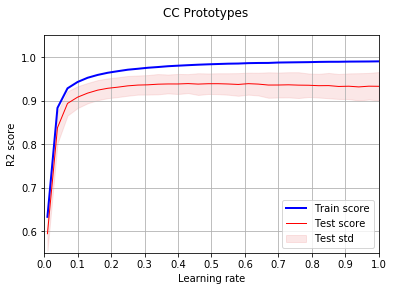

In [18]:
plt.clf()
plt.plot(np.arange(0.01, 1.01, 0.03), train_score.loc['Mean'], label = 'Train score', color='b', linewidth=2)
plt.plot(np.arange(0.01, 1.01, 0.03), test_score.loc['Mean'], label = 'Test score', color='r', linewidth=1)

plt.fill_between(np.arange(0.01, 1.01, 0.03), list(test_score.loc['Mean']-test_score.loc['std']),
                 list(test_score.loc['Mean']+test_score.loc['std']), color = '#ed8787', alpha = 0.2, label = 'Test std')

plt.xlabel('Learning rate')
plt.ylabel('R2 score')
plt.suptitle(name)
plt.grid(True)
plt.xticks(np.linspace(0,1,11))
plt.xlim([0, 1])
plt.ylim([0.55, 1.05])

ax = plt.subplot(111)
ax.legend(loc='lower right')

#plt.savefig('Images/9 '+ name +' LR x score.png', dpi = 300)

# Learning rate x n_estimators

In [19]:
#iterating n_estimators

import random

lr = np.array(np.arange(0.1,0.7,0.1))
lr = [round(i_lr, 1) for i_lr in lr]
n_estimators = np.arange(1, 100, 1)
iterations = 100
name = 'CC Prototypes'

train_score = pd.DataFrame(0, index = n_estimators, columns = ['Train r2 (lr = ' + str(i_lr) + ')' for i_lr in lr])
test_score = pd.DataFrame(0, index = n_estimators, columns = ['Test r2 (lr = ' + str(i_lr) + ')' for i_lr in lr])
train_std = pd.DataFrame(0, index = n_estimators, columns = ['Train r2 (lr = ' + str(i_lr) + ')' for i_lr in lr])
test_std = pd.DataFrame(0, index = n_estimators, columns = ['Test r2 (lr = ' + str(i_lr) + ')' for i_lr in lr])

for i in range(iterations):
    X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(df_input_prod, df_output.loc[:,name],
                                                                            test_size = 0.25, random_state = int(time.time()))
    for i_lr in lr:
        for j in n_estimators:
            model = GradientBoostingRegressor(n_estimators = int(j), learning_rate = i_lr)
            model.fit(X_train_prod, y_train_prod)

            train_old_mean = train_score.iloc[int(j)-1,lr.index(i_lr)]
            test_old_mean = test_score.iloc[int(j)-1,lr.index(i_lr)]
            x_train = model.score(X_train_prod, y_train_prod)
            x_test = model.score(X_test_prod, y_test_prod)
            
            train_score.iloc[int(j)-1,lr.index(i_lr)] += (x_train - train_score.iloc[int(j)-1,lr.index(i_lr)])/(i+1)
            test_score.iloc[int(j)-1,lr.index(i_lr)] += (x_test - test_score.iloc[int(j)-1,lr.index(i_lr)])/(i+1)
            train_std.iloc[int(j)-1,lr.index(i_lr)] += (x_train - train_old_mean) * (x_train - train_score.iloc[int(j)-1,lr.index(i_lr)]) 
            test_std.iloc[int(j)-1,lr.index(i_lr)] += (x_test - test_old_mean) * (x_test - test_score.iloc[int(j)-1,lr.index(i_lr)]) 
   
    print('\r {} / {}'.format(i+1, iterations), end='')
train_std = np.sqrt(train_std/(iterations-1))
test_std = np.sqrt(test_std/(iterations-1))
final_score = pd.concat({name:train_score, 'test': test_score}, axis = 1)
final_score.to_csv(r'ML_Export.csv')

 100 / 100

In [20]:
[list(np.max(train_std)), list(np.mean(train_std)), list(np.max(test_std)), list(np.mean(test_std))]

[[0.022010289629370742,
  0.02241776006790176,
  0.026788788297634553,
  0.026898702419083983,
  0.02918956806281854,
  0.0313429615474415],
 [0.010852956762683453,
  0.008142521447746826,
  0.006934388493868018,
  0.00641601221134386,
  0.005927069534938784,
  0.006286746298646374],
 [0.04716120872882314,
  0.04934667149523639,
  0.05241618959207528,
  0.05788094256270708,
  0.0649309330495904,
  0.06703056194399647],
 [0.03971363107097497,
  0.03358776395312619,
  0.031014693905979888,
  0.028706015294968367,
  0.028600417318016165,
  0.030764081576416347]]

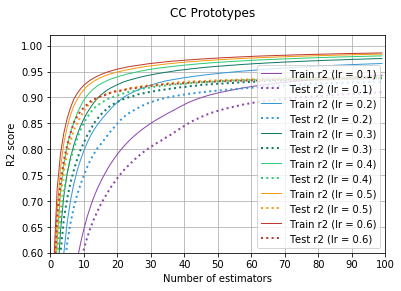

In [21]:
#plotting learning rate comparison
plt.clf()
lr = [0.1,0.2,0.3,0.4,0.5,0.6]
colors = ['#8E44AD','#3498DB','#117A65','#2ECC71','#F39C12','#C0392B']
for i in range(len(lr)):
    train = 'Train r2 (lr = '+ str(lr[i]) +')'
    test = 'Test r2 (lr = '+ str(lr[i]) +')'
    plt.plot(np.arange(len(n_estimators)) + 1, train_score.loc[:, train], color=colors[i], linewidth=1)
    plt.plot(np.arange(len(n_estimators)) + 1, test_score.loc[:,test], color=colors[i], linewidth=2, linestyle = ':')

plt.axis([0, 100, 0.6, 1.02])
plt.xlabel('Number of estimators')
plt.ylabel('R2 score')
plt.suptitle(name)
plt.grid(True)
plt.xticks(np.linspace(0,100,11))

ax = plt.subplot(111)
ax.legend(loc='lower right')

#plt.savefig('Images/9 '+name+' LR all.png', dpi = 300)

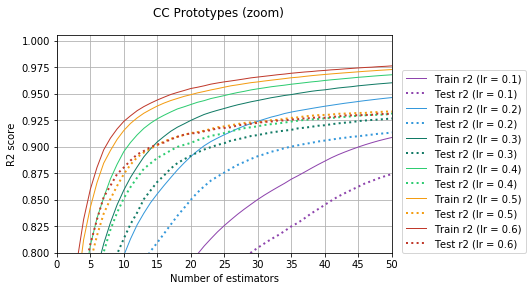

In [22]:
plt.clf()

lr = [0.1,0.2,0.3,0.4,0.5,0.6]
colors = ['#8E44AD','#3498DB','#117A65','#2ECC71','#F39C12','#C0392B']
for i in range(len(lr)):
    train = 'Train r2 (lr = '+ str(lr[i]) +')'
    test = 'Test r2 (lr = '+ str(lr[i]) +')'
    plt.plot(np.arange(len(n_estimators)) + 1, train_score.loc[:, train], color=colors[i], linewidth=1)
    plt.plot(np.arange(len(n_estimators)) + 1, test_score.loc[:,test], color=colors[i], linewidth=2, linestyle = ':')

plt.axis([0, 50, 0.8, 1.005])
plt.xlabel('Number of estimators')
plt.ylabel('R2 score')
plt.suptitle(name+' (zoom)')
plt.grid(True)
plt.xticks(np.linspace(0,50,11))

ax = plt.subplot(111)

ax.legend(loc='lower right', bbox_to_anchor=(1.4, 0), borderaxespad=0.)

#plt.savefig('Images/9 '+name+' LR all zoom.png', dpi = 300, bbox_inches  = 'tight')

# Max_depth

In [23]:
#iterating max_depth

n_estimators = np.linspace(1,50,50)
max_depth = np.linspace(1,9,5)
train_score = pd.DataFrame(0, index = n_estimators, columns = ['Train r2 (md = ' + str(int(md)) + ')' for md in max_depth])
test_score = pd.DataFrame(0, index = n_estimators, columns = ['Test r2 (md = ' + str(int(md)) + ')' for md in max_depth])
train_std = pd.DataFrame(0, index = n_estimators, columns = ['Train r2 (md = ' + str(int(md)) + ')' for md in max_depth])
test_std = pd.DataFrame(0, index = n_estimators, columns = ['Test r2 (md = ' + str(int(md)) + ')' for md in max_depth])
iterations = 100

name = 'CC Prototypes'

for i in range(iterations):
    X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(df_input_prod, df_output.loc[:,name],
                                                                            test_size = 0.25, random_state = int(time.time()))
    for md in max_depth:
        for j in n_estimators:
            model = GradientBoostingRegressor(n_estimators = int(j), learning_rate = 0.4, max_depth = int(md))
            model.fit(X_train_prod, y_train_prod)
            train_old_mean = train_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])]
            test_old_mean = test_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])]
            x_train = model.score(X_train_prod, y_train_prod)
            x_test = model.score(X_test_prod, y_test_prod)
            train_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])] += (x_train - train_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])])/(i+1)
            test_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])] += (x_test - test_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])])/(i+1)
            train_std.iloc[int(j)-1,int(np.where(max_depth == md)[0])] += (x_train - train_old_mean) * (x_train - train_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])]) 
            test_std.iloc[int(j)-1,int(np.where(max_depth == md)[0])] += (x_test - test_old_mean) * (x_test - test_score.iloc[int(j)-1,int(np.where(max_depth == md)[0])]) 

    print('\r {} / {}'.format(i+1, iterations), end='')
train_std = np.sqrt(train_std/(iterations-1))
test_std = np.sqrt(test_std/(iterations-1))
final_score = pd.concat({name:train_score, 'test': test_score}, axis = 1)
final_score.to_csv(r'ML_Export.csv')

 100 / 100

In [24]:
[list(np.max(train_std)), list(np.mean(train_std)), list(np.max(test_std)), list(np.mean(test_std))]

[[0.018623362027685407,
  0.037014304535626874,
  0.02219385480395634,
  0.013917093743244412,
  0.006319771451107734],
 [0.014620861439719584,
  0.009363509585726189,
  0.004239112437223052,
  0.00312603537910318,
  0.002644880865540128],
 [0.041190884668756374,
  0.07111739734580018,
  0.04146474347411568,
  0.046106893757395614,
  0.06552343730085022],
 [0.03892479994478251,
  0.03654827058203727,
  0.03147058060283196,
  0.043573062622217294,
  0.05824799685044635]]

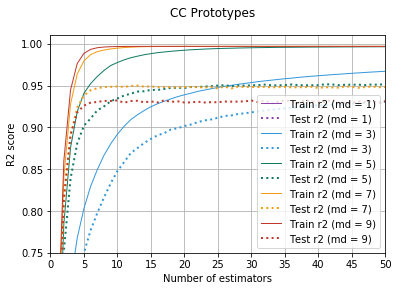

In [25]:
#plotting max_depth r2 comparison
plt.clf()

max_depth = np.linspace(1,9,5)
colors = ['#8E44AD','#3498DB','#117A65','#F39C12','#C0392B']
for i in range(len(max_depth)):
    train = 'Train r2 (md = '+ str(int(max_depth[i])) +')'
    test = 'Test r2 (md = '+ str(int(max_depth[i])) +')'
    plt.plot(np.arange(len(n_estimators)) + 1, train_score.loc[:, train], color=colors[i], linewidth=1)
    plt.plot(np.arange(len(n_estimators)) + 1, test_score.loc[:,test], color=colors[i], linewidth=2, linestyle = ':')


plt.axis([0, 50, 0.75, 1.01])
plt.xlabel('Number of estimators')
plt.ylabel('R2 score')
plt.suptitle(name)
plt.grid(True)
plt.xticks(np.linspace(0,50,11))

ax = plt.subplot(111)
ax.legend(loc='lower right')

#plt.savefig('Images/9 '+name+' max_depth.png', dpi = 300, bbox_inches  = 'tight')

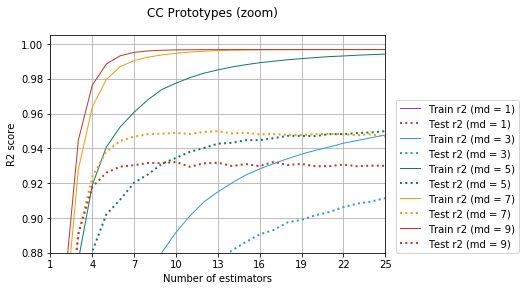

In [26]:
#plotting max_depth r2 comparison
plt.clf()

max_depth = np.linspace(1,9,5)
colors = ['#8E44AD','#3498DB','#117A65','#F39C12','#C0392B']
for i in range(len(max_depth)):
    train = 'Train r2 (md = '+ str(int(max_depth[i])) +')'
    test = 'Test r2 (md = '+ str(int(max_depth[i])) +')'
    plt.plot(np.arange(len(n_estimators)) + 1, train_score.loc[:, train], color=colors[i], linewidth=1)
    plt.plot(np.arange(len(n_estimators)) + 1, test_score.loc[:,test], color=colors[i], linewidth=2, linestyle = ':')


plt.axis([1, 25, 0.88, 1.005])
plt.xlabel('Number of estimators')
plt.ylabel('R2 score')
plt.suptitle(name+' (zoom)')
plt.grid(True)
plt.xticks(np.linspace(1,25,9))

ax = plt.subplot(111)
ax.legend(loc='lower right', bbox_to_anchor=(1.4, 0), borderaxespad=0.)

#plt.savefig('Images/9 '+name+' max_depth zoom.png', dpi = 300, bbox_inches  = 'tight')

# GBRT visualization and feature_importance

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

score_prod = pd.DataFrame(index = list(df_output.columns.values), columns = ['Train score', 'Test score'])
feature_importances = pd.DataFrame(index = list(df_output.columns.values), columns = df_input_prod.columns.values)

for i in range(df_output.shape[1]):
    X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(df_input_prod, df_output.iloc[:,i],
                                                                        test_size = 0.25, random_state = int(time.time()))
    
    estimator = GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 30, max_depth = 5)
    estimator.fit(X_train_prod, y_train_prod)
    
    score_train = estimator.score(X_train_prod, y_train_prod)
    score_test = estimator.score(X_test_prod, y_test_prod)
    score_prod.iloc[i] = [score_train, score_test]
    feature_importances.iloc[i] = estimator.feature_importances_
    
#score_prod_gridsearch.to_csv(r'ML_Export.csv')
score_prod

FI = feature_importances

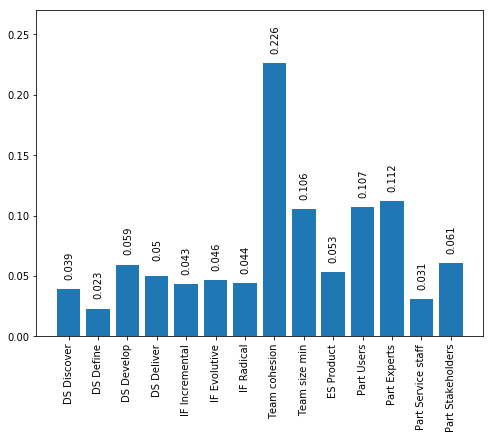

In [5]:
plt.figure(num=None, figsize=(8, 6))
labels = FI.columns
heights = FI.mean().values
plt.bar(x = labels, height = heights)
plt.xticks(rotation = 90)
for i, v in enumerate(heights):
    plt.text(i-0.15, v+0.025, str(round(v,3)), color='black', rotation = 90)
plt.ylim([0, 0.27])
plt.show()

In [6]:
feature_importances.mean()

DS Discover           0.039304
DS Define             0.022944
DS Develop            0.059341
DS Deliver            0.049692
IF Incremental        0.042928
IF Evolutive          0.046421
IF Radical            0.044089
Team cohesion         0.226151
Team size min         0.105507
ES Product            0.053404
Part Users            0.107167
Part Experts          0.111734
Part Service staff    0.030768
Part Stakeholders     0.060549
dtype: float64

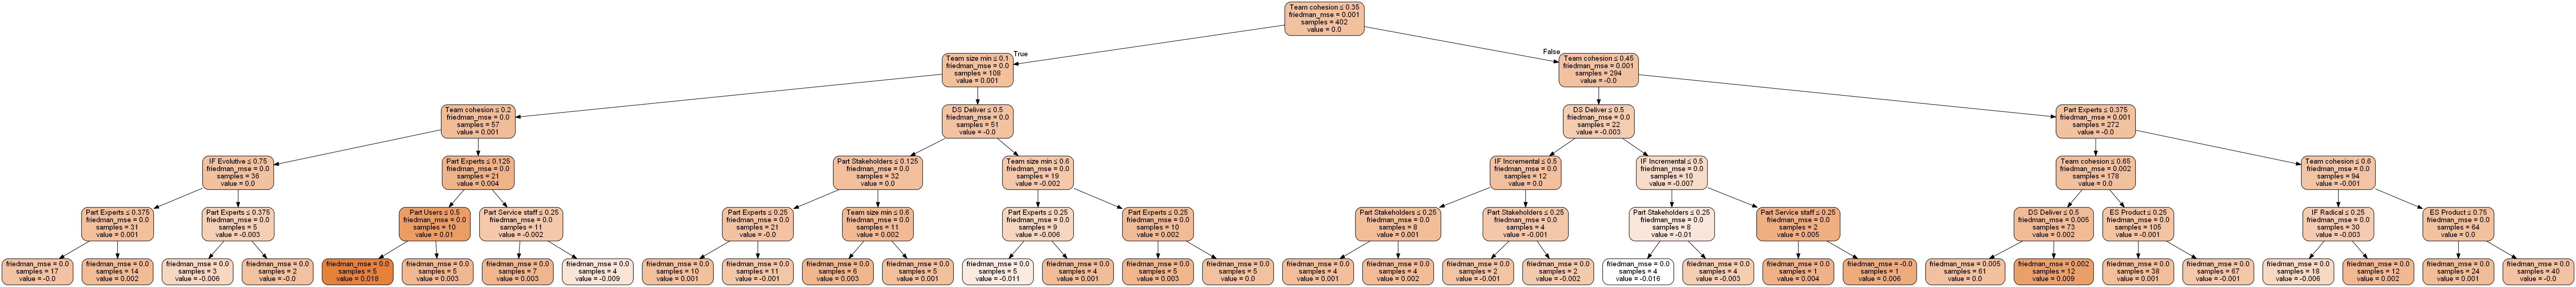

In [8]:
estimator_tree = estimator.estimators_[29, 0]

from sklearn import tree

# Export as dot file
'''tree.export_graphviz(estimator_tree, out_file='tree.dot', 
                feature_names = df_input_prod.columns.values,
                rounded = True, proportion = False, 
                precision = 2, filled = True)'''

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

dot_data = StringIO()
tree.export_graphviz(estimator_tree, out_file=dot_data,
                     feature_names = df_input_prod.columns.values,
                     filled=True, rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

# time test

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()
predicted_values = []
for i in range(10):
    for i in range(df_output.shape[1]):
        #X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(df_input_prod, df_output.iloc[:,i],
        #                                                                    test_size = 0.25, random_state = int(time.time()))
        X = df_input_prod
        y = df_output.iloc[:,i]
        estimator = GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 30, max_depth = 5)
        estimator.fit(X, y)
        score_train = estimator.score(X, y)
        new_case = pd.DataFrame(np.array([[1,0,0,0,0.3,0.5,0.1,0.5,1,1,1,0,1,0]]), columns = df_input_prod.columns.values)
        predicted_values.append(estimator.predict(new_case))
(time.time() - start)/10

0.279892110824585